In [3]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from sklearn.utils import shuffle
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image as keras_image
from lime.lime_image import LimeImageExplainer


In [12]:
def file_paths(paths_with_labels):
    filepaths = []
    labels = []
    for path, label in paths_with_labels:
        if not os.path.exists(path):
            print(f"Warning: Path does not exist: {path}")
            continue
        for file in os.listdir(path):
            fpath = os.path.join(path, file)
            if os.path.isfile(fpath):
                filepaths.append(fpath)
                labels.append(label)
    return filepaths, labels

def define_df(files, classes):
    return pd.DataFrame({'filepaths': files, 'labels': classes})

def create_df():
    # Define training sources and labels manually
    train_sources = [
        ("/kaggle/input/stroke/New_data_Stroke_ver3/CT/HEMORAGE STROK", "hemorrhagic"),
        ("/kaggle/input/stroke/New_data_Stroke_ver3/CT/ISCHAEMIC SRTROK", "ischaemic"),
        ("/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Train/hemorrhagic", "hemorrhagic"),
        ("/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Train/ischaemic", "ischaemic"),
    ]
    
    val_dir = "/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation"
    test_dir = "/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Test"

    train_files, train_classes = file_paths(train_sources)
    train_df = define_df(train_files, train_classes)

    val_files, val_classes = file_paths([(os.path.join(val_dir, folder), folder) for folder in os.listdir(val_dir)])
    valid_df = define_df(val_files, val_classes)

    test_files, test_classes = file_paths([(os.path.join(test_dir, folder), folder) for folder in os.listdir(test_dir)])
    test_df = define_df(test_files, test_classes)

    return train_df, valid_df, test_df


In [13]:
train_dataframe, validation_dataframe, test_dataframe = create_df()

print("Train:", train_dataframe.shape)
print("Validation:", validation_dataframe.shape)
print("Test:", test_dataframe.shape)


Train: (2954, 2)
Validation: (235, 2)
Test: (437, 2)


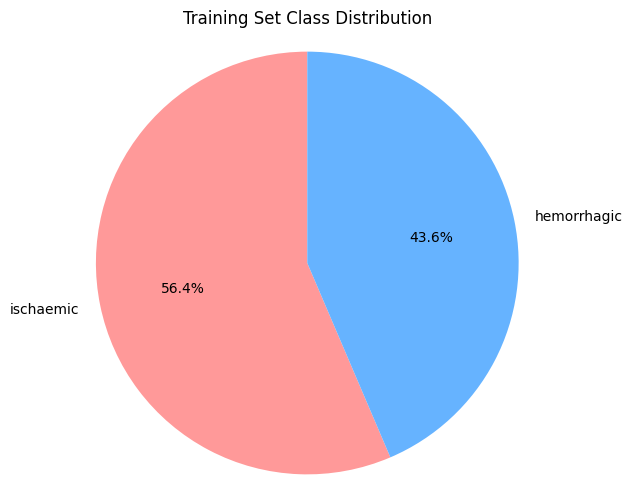

In [15]:
class_counts = train_dataframe['labels'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Training Set Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle.
plt.show()


In [36]:
train_dataframe = train_dataframe.rename(columns={'filepaths': 'image_path'})

In [74]:
validation_dataframe = validation_dataframe.rename(columns={'filepaths': 'image_path'})
test_dataframe = test_dataframe.rename(columns={'filepaths': 'image_path'})

In [48]:
train_dataframe['labels'].value_counts()

labels
ischaemic      1667
hemorrhagic    1287
Name: count, dtype: int64

In [104]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [105]:
class StrokeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform
        self.label_map = {'hemorrhagic': 0, 'ischaemic': 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        label = self.label_map[self.data.iloc[idx]['labels']]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [106]:
# ImageNet normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = StrokeDataset(train_dataframe, transform=train_transform)
val_dataset = StrokeDataset(validation_dataframe, transform=val_test_transform)
test_dataset = StrokeDataset(test_dataframe, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [107]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataframe['labels']),
    y=train_dataframe['labels']
)

class_weights = torch.tensor(class_weights, dtype=torch.float32)
print("Class Weights:", class_weights)


Class Weights: tensor([1.1476, 0.8860])


In [119]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return torch.softmax(x, dim=1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=2).to(device)


In [120]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [121]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data).item()
            total_train += labels.size(0)

        scheduler.step()

        avg_train_loss = train_loss / total_train
        train_acc = train_correct / total_train

        val_loss, val_acc = evaluate(model, val_loader, criterion)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history

def evaluate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data).item()
            total += labels.size(0)

    avg_val_loss = val_loss / total
    val_acc = correct / total
    return avg_val_loss, val_acc


In [122]:
history=train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20, Train Loss: 0.6689, Train Acc: 0.5914, Val Loss: 0.7738, Val Acc: 0.4681
Epoch 2/20, Train Loss: 0.6148, Train Acc: 0.6632, Val Loss: 0.6080, Val Acc: 0.6766
Epoch 3/20, Train Loss: 0.5930, Train Acc: 0.6933, Val Loss: 0.5948, Val Acc: 0.7021
Epoch 4/20, Train Loss: 0.5742, Train Acc: 0.7211, Val Loss: 0.5731, Val Acc: 0.7149
Epoch 5/20, Train Loss: 0.5566, Train Acc: 0.7495, Val Loss: 0.5702, Val Acc: 0.7234
Epoch 6/20, Train Loss: 0.5315, Train Acc: 0.7715, Val Loss: 0.5370, Val Acc: 0.7745
Epoch 7/20, Train Loss: 0.5105, Train Acc: 0.7989, Val Loss: 0.5419, Val Acc: 0.7404
Epoch 8/20, Train Loss: 0.5110, Train Acc: 0.7921, Val Loss: 0.5721, Val Acc: 0.7191
Epoch 9/20, Train Loss: 0.5001, Train Acc: 0.8067, Val Loss: 0.5720, Val Acc: 0.7021
Epoch 10/20, Train Loss: 0.4795, Train Acc: 0.8246, Val Loss: 0.5010, Val Acc: 0.7957
Epoch 11/20, Train Loss: 0.4775, Train Acc: 0.8301, Val Loss: 0.4966, Val Acc: 0.8085
Epoch 12/20, Train Loss: 0.4666, Train Acc: 0.8439, Val Loss: 0

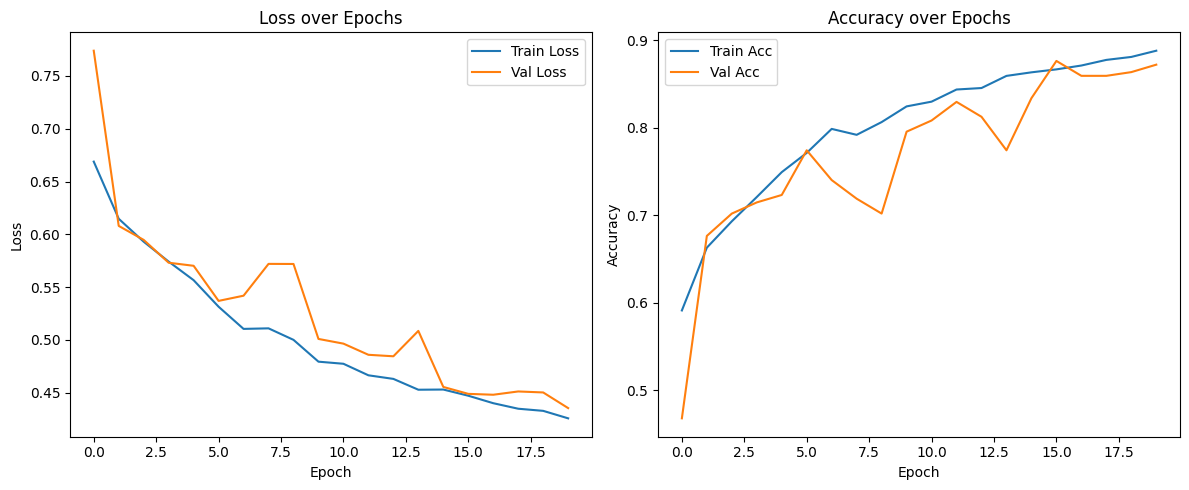

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Loss Plot
axs[0].plot(history['train_loss'], label='Train Loss')
axs[0].plot(history['val_loss'], label='Val Loss')
axs[0].set_title('Loss over Epochs')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

# Accuracy Plot
axs[1].plot(history['train_acc'], label='Train Acc')
axs[1].plot(history['val_acc'], label='Val Acc')
axs[1].set_title('Accuracy over Epochs')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [124]:
from sklearn.metrics import classification_report
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
total_loss = 0.0
correct = 0
total = 0

criterion = nn.CrossEntropyLoss()  # تأكد أنك استخدم نفس الـ criterion اللي دربت بيه

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

avg_loss = total_loss / total
accuracy = correct / total

# طباعة النتائج
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Loss: {avg_loss:.4f}\n")
print(classification_report(all_labels, all_preds, target_names=['hemorrhagic', 'ischaemic']))



Test Accuracy: 0.8307
Test Loss: 0.4633

              precision    recall  f1-score   support

 hemorrhagic       0.70      0.75      0.72       130
   ischaemic       0.89      0.87      0.88       307

    accuracy                           0.83       437
   macro avg       0.80      0.81      0.80       437
weighted avg       0.83      0.83      0.83       437



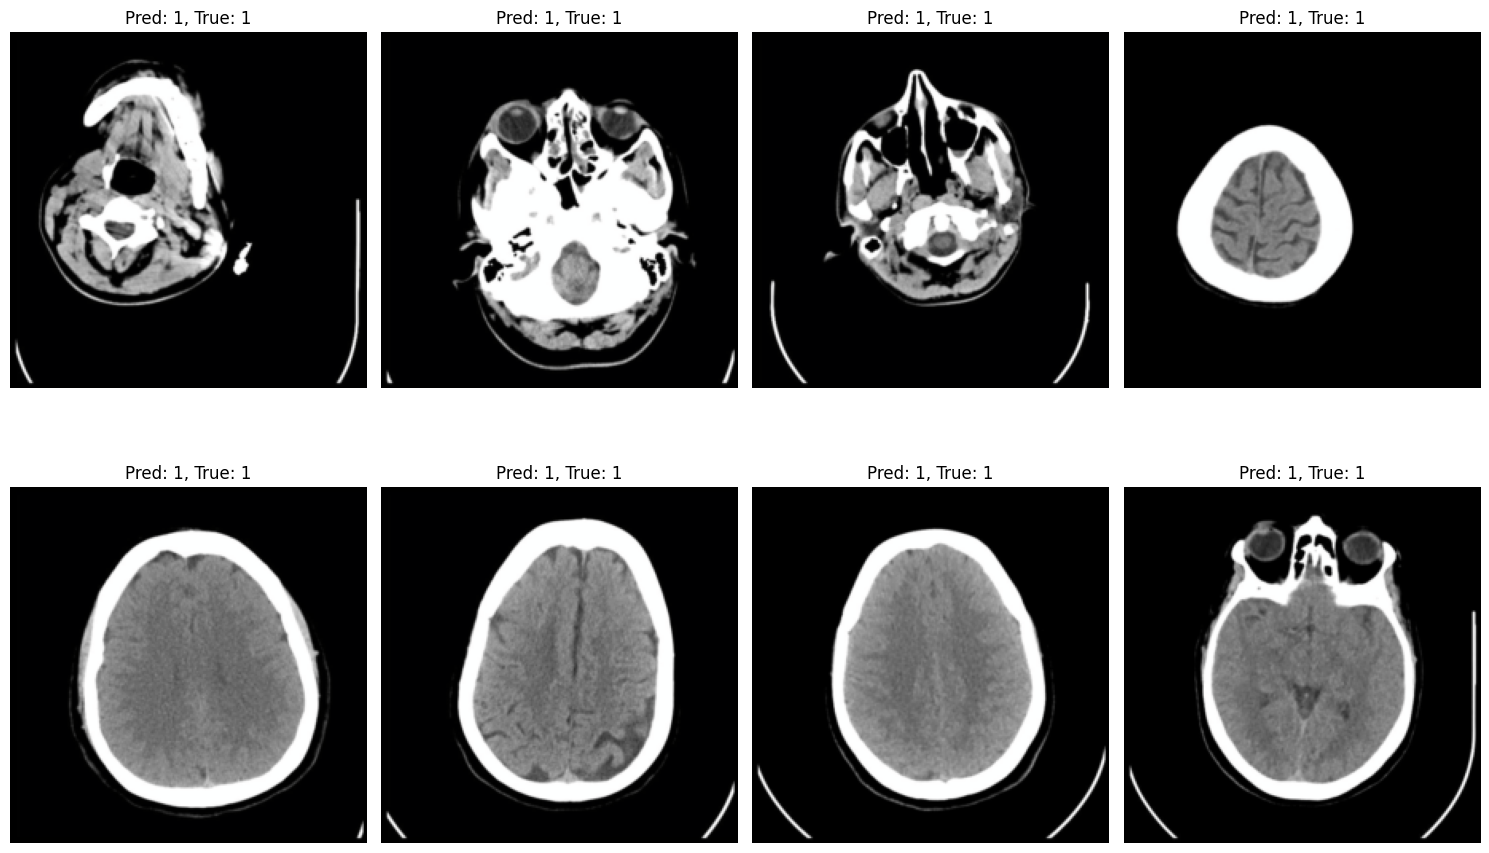

In [125]:
def imshow(img, title):
    img = img.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Show 8 predictions
model.eval()
images_shown = 0
plt.figure(figsize=(15, 10))

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    for i in range(images.size(0)):
        if images_shown >= 8:
            break
        plt.subplot(2, 4, images_shown+1)
        imshow(images[i], f"Pred: {preds[i].item()}, True: {labels[i].item()}")
        images_shown += 1
    if images_shown >= 8:
        break

plt.tight_layout()
plt.show()
